##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CycleGAN

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cyclegan"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.org에서 보기</a> </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/cyclegan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 노트북은 CycleGAN이라고도 하는[Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)에 설명된 것처럼 조건부 GAN을 사용하여 쌍으로 연결되지 않은 이미지 간 변환을 보여줍니다. 이 논문은 한 쌍의 훈련 예제가 없을 때 하나의 이미지 도메인의 특성을 포착하고 이러한 특성이 다른 이미지 도메인으로 어떻게 변환될 수 있는지 알아낼 수있는 방법을 제안합니다.

이 노트북은 독자가 [Pix2Pix 튜토리얼](https://www.tensorflow.org/tutorials/generative/pix2pix)에서 배울 수 있는 Pix2Pix에 익숙하다고 가정합니다. CycleGAN의 코드는 비슷하며, 주된 차이점은 추가 손실 함수와 쌍으로 연결되지 않은 훈련 데이터를 사용한다는 점입니다.

CycleGAN은 주기 일관성 손실을 사용하여 쌍으로 연결된 데이터 없이도 훈련을 수행할 수 있습니다. 즉, 소스와 대상 도메인 사이에서 일대일 매핑 없이 한 도메인에서 다른 도메인으로 변환할 수 있습니다.

이를 통해 사진 향상, 이미지 색상 지정, 스타일 전송 등과 같은 많은 흥미로운 작업을 수행할 수 있습니다. 소스와 대상 데이터세트(단순히 이미지 디렉토리)만 있으면 됩니다.

![Output Image 1](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/horse2zebra_1.png?raw=1)![Output Image 2](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/horse2zebra_2.png?raw=1)

## 입력 파이프라인 설정하기

생성기와 판별자 가져오기를 지원하는 [tensorflow_examples](https://github.com/tensorflow/examples) 패키지를 설치합니다.

In [2]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-_nnpccp6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-_nnpccp6
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=8999309048ab5d186d67b3691a4031cd66ea80e2e52f6075c13fb2ab801406a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-hrmgqb71/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## 입력 파이프라인

이 튜토리얼에서는 말의 이미지에서 얼룩말의 이미지로 변환하도록 모델을 훈련합니다. 이 데이터세트 및 이와 유사한 데이터세트는 [여기](https://www.tensorflow.org/datasets/datasets#cycle_gan)에서 찾을 수 있습니다.

[논문](https://arxiv.org/abs/1703.10593)에 언급된 바와 같이 훈련 데이터세트에 임의의 지터링 및 미러링을 적용합니다. 이것은 과대적합을 피하는 이미지 강화 기법들입니다.

이 작업은 [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)에서 수행한 것과 비슷합니다.

- 무작위 지터링에서 이미지는 `286 x 286` 크기로 조정된 후 `256 x 256`로 무작위로 잘립니다.
- 랜덤 미러링에서는 이미지가 좌우로 무작위로 뒤집힙니다.

In [5]:
dataset, metadata = tfds.load('Cycle_gan/monet2photo',
                              with_info=True, as_supervised=True)

train_monet, train_photo = dataset['trainA'], dataset['trainB']
test_monet, test_photo = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1072 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/3.0.0.incompleteYN662U/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/3.0.0.incompleteYN662U/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/121 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/3.0.0.incompleteYN662U/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/751 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/3.0.0.incompleteYN662U/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/3.0.0. Subsequent calls will reuse this data.


In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [12]:
train_monet = train_monet.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_photo = train_photo.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_monet = test_monet.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
sample_monet = next(iter(train_monet))
sample_photo = next(iter(train_photo))

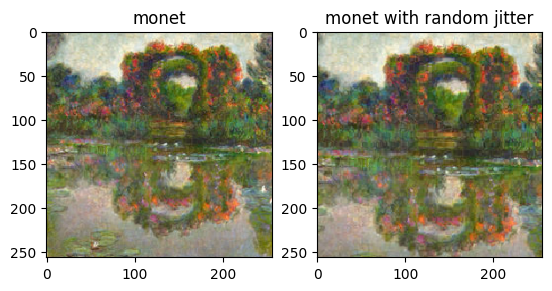

In [14]:
plt.subplot(121)
plt.title('monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('monet with random jitter')
plt.imshow(random_jitter(sample_monet[0]) * 0.5 + 0.5)

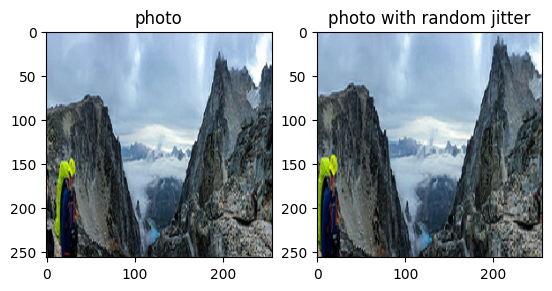

In [15]:
plt.subplot(121)
plt.title('photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

## Pix2Pix 모델 가져오기 및 재사용하기

설치된 [tensorflow_examples](https://github.com/tensorflow/examples) 패키지를 통해 [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)에서 사용되는 생성기와 판별자를 가져옵니다.

이 튜토리얼에서 사용된 모델 아키텍처는 [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py)에서 사용된 것과 매우 유사합니다. 몇 가지 차이점은 다음과 같습니다.

- Cyclegan은 [배치 정규화](https://arxiv.org/abs/1502.03167) 대신 [인스턴스 정규화](https://arxiv.org/abs/1607.08022)를 사용합니다.
- [CycleGAN 논문](https://arxiv.org/abs/1703.10593)에서는 수정된 `resnet` 기반 생성기를 사용합니다. 이 튜토리얼에서는 단순화를 위해 수정된 `unet` 생성기를 사용합니다.

여기서는 2개의 생성기(G 및 F)와 2개의 판별자(X 및 Y)를 훈련합니다.

- 생성기 `G`는 이미지 `X`를 이미지 `Y`로 변환하는 방법을 학습합니다. $(G: X -&gt; Y)$
- 생성기 `F`는 이미지 `Y`를 이미지 `X`로 변환하는 방법을 학습합니다. $(F: Y -&gt; X)$
- 판별자 `D_X`는 이미지 `X`와 생성된 이미지 `X`( `F(Y)` )를 구별하는 방법을 학습합니다.
- 판별자 `D_Y`는 이미지 `Y`와 생성된 이미지 `Y`(`G(X)`)를 구별하는 방법을 학습합니다.

![Cyclegan model](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/cyclegan_model.png?raw=1)

In [16]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

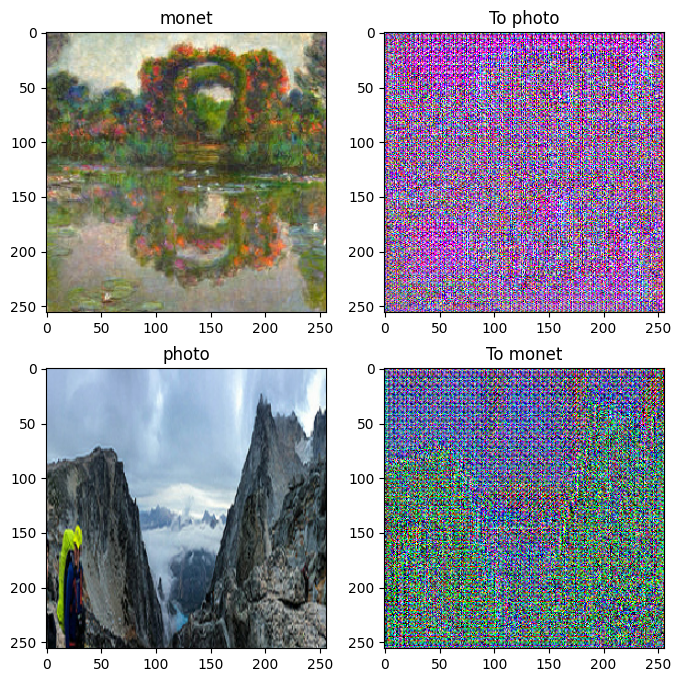

In [17]:
to_photo = generator_g(sample_monet)
to_monet = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_monet, to_photo, sample_photo, to_monet]
title = ['monet', 'To photo', 'photo', 'To monet']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

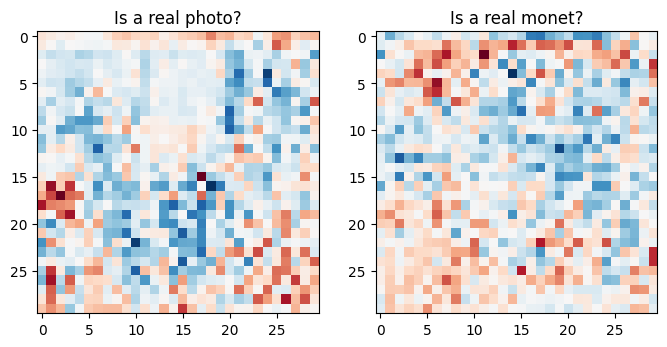

In [18]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real photo?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real monet?')
plt.imshow(discriminator_x(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.show()

## 손실 함수

CycleGAN에는 훈련할 쌍으로 연결된 데이터가 없으므로 훈련 중에 입력 `x`와 대상 `y`의 쌍이 의미가 있다는 보장이 없습니다. 따라서 네트워크가 올바른 매핑을 학습하도록 강제하기 위해 저자들은 주기 일관성 손실을 제안합니다.

판별자 손실 및 생성기 손실은 [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer)에 사용된 것과 유사합니다.

In [19]:
LAMBDA = 10

In [20]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [22]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

주기 일관성은 결과가 원래 입력에 가까워야 함을 의미합니다. 예를 들어 문장을 영어에서 프랑스어로 번역한 다음 다시 프랑스어에서 영어로 번역하면 결과 문장은 원래 문장과 같아야 합니다.

주기 일관성 손실에서,

- $X$ 이미지는 $G$ 생성기를 통해 전달되어 $\hat{Y}$의 생성된 이미지가 만들어집니다.
- $\hat{Y}$의 생성된 이미지는 $F$ 생성기를 통해 전달되어 $\hat{X}$의 순환 이미지를 생성합니다.
- $X$ 및 $\hat{X}$ 사이에서 평균 절대 오차가 계산됩니다.

![Cycle loss](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/cycle_loss.png?raw=1)

![주기 손실](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/cycle_loss.png?raw=1)

![Cycle loss](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/cycle_loss.png?raw=1)

In [23]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

위에서 볼 수 있듯이 $G$ 생성기는 $X$ 이미지를 $Y$ 이미지로 변환하는 역할을 합니다. ID 손실은 $Y$ 이미지를 $G$ 생성기에 공급하면 실제 이미지 $Y$ 또는 이미지 $Y$에 가까운 이미지를 생성해야 한다고 지시합니다.

말에서 얼룩말-말 모델을 실행하거나 얼룩말에서 말-얼룩말 모델을 실행하는 경우 이미지에 이미 대상 클래스가 포함되어 있으므로 이미지를 많이 수정하지 않아야 합니다.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [24]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

모든 생성기 및 판별자의 옵티마이저를 초기화합니다.

In [25]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 체크포인트

In [26]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## 훈련하기

참고: 이 예제 모델은 이 튜토리얼에 적합한 훈련 시간을 유지하도록 논문(200)보다 적은 epoch(10) 동안 훈련되었습니다. 생성된 이미지의 품질은 훨씬 낮습니다.

In [27]:
EPOCHS = 10

In [28]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

훈련 루프가 복잡해 보이지만 네 가지 기본 단계로 구성됩니다.

- 예측을 얻습니다.
- 손실을 계산합니다.
- 역전파를 사용하여 그래디언트를 계산합니다.
- 그래디언트를 옵티마이저에 적용합니다.

In [29]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

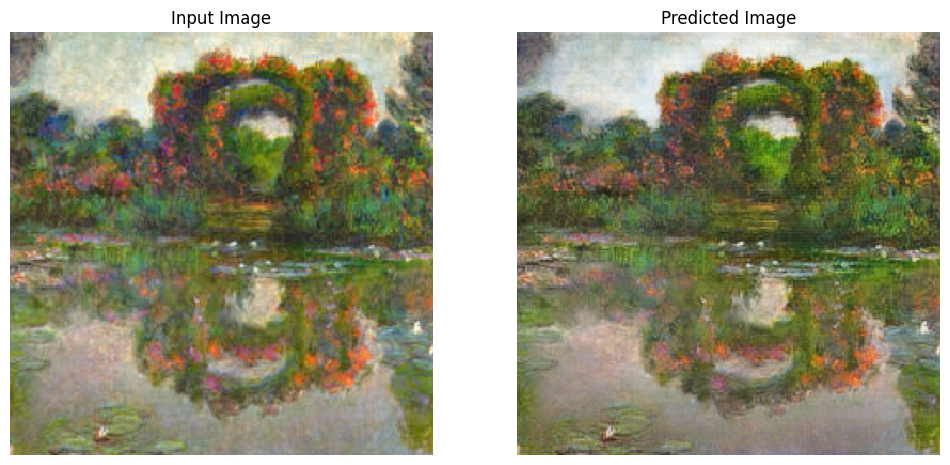

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 465.92708349227905 sec



In [30]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_monet, train_photo)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_monet) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_monet)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

## 테스트 데이터세트를 사용하여 생성하기

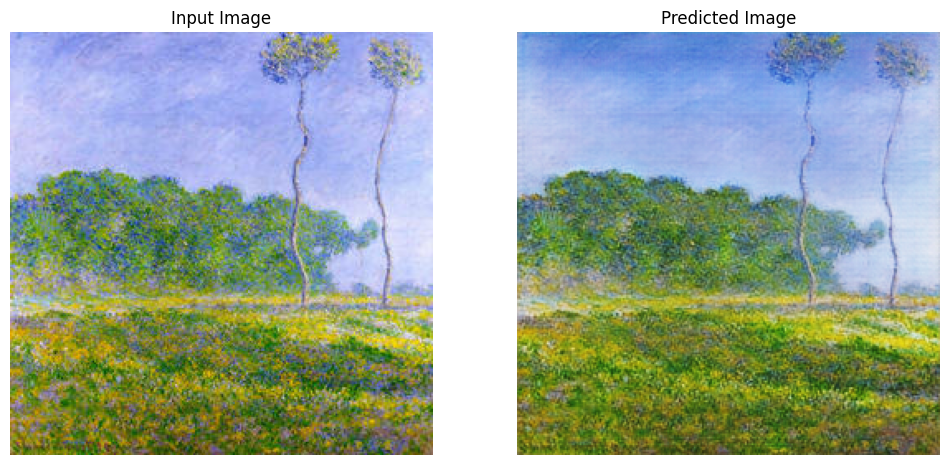

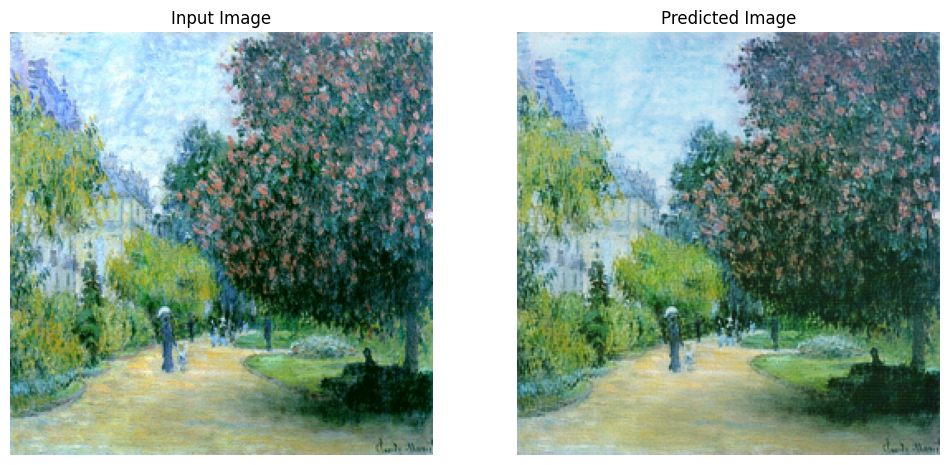

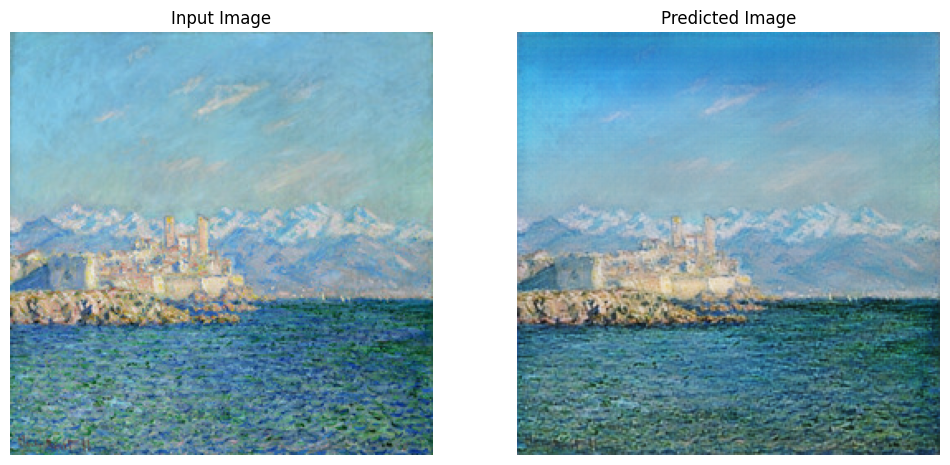

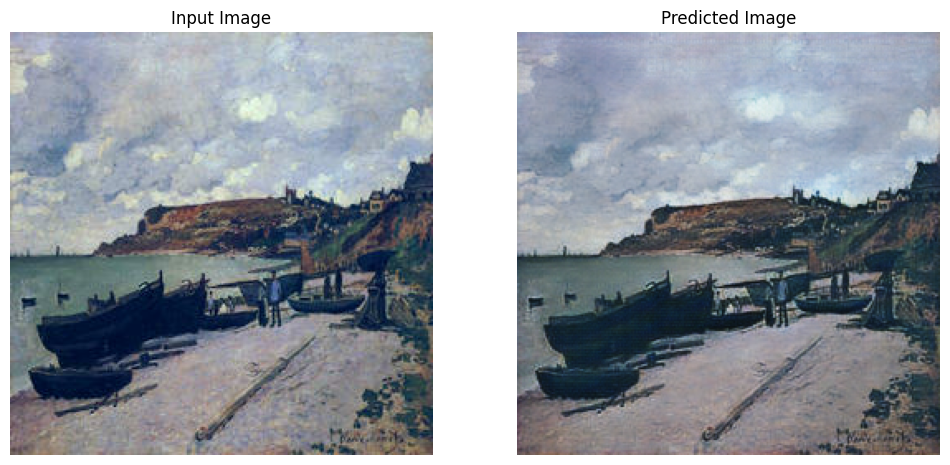

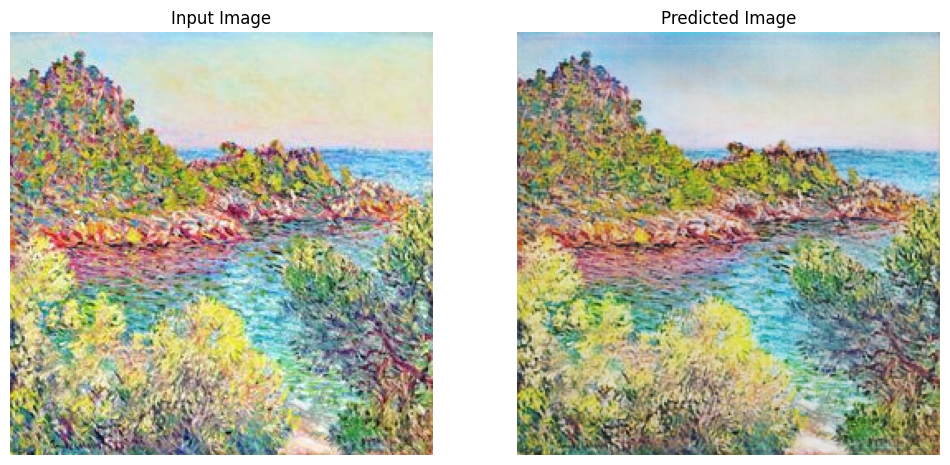

In [31]:
# Run the trained model on the test dataset
for inp in test_monet.take(5):
  generate_images(generator_g, inp)

## 다음 단계

이 튜토리얼에서는 [Pix2Pix](https://www.tensorflow.org/tutorials/generative/pix2pix) 튜토리얼에서 구현된 생성기 및 판별자부터 시작하여 CycleGAN을 구현하는 방법을 알아보았습니다. 다음 단계에서는 [TensorFlow 데이터세트](https://www.tensorflow.org/datasets/datasets#cycle_gan)와 다른 데이터세트를 이용해 볼 수 있습니다.

결과를 개선하기 위해 더 많은 epoch 동안 훈련하거나 여기에 사용된 U-Net 생성기 대신 [논문](https://arxiv.org/abs/1703.10593)에 사용된 수정된 ResNet 생성기를 구현할 수도 있습니다.